## Examples

We are going to use two examples to illustrate how to use Kulprit for variable selection. 

* Body Fat: We will use the bodyfat data set {cite}`Penrose_1985`. The aim of the analysis is to predict an expensive and cumbersome water immersion measurement of body fat percentage (observed variable named `siri`) from a set of thirteen easier to measure characteristics, including `age`, `height`, `weight`, and `circumferences` of various body parts.

* Bikes: This dataset contains the number of bike rentals per hour (`count`) in a bike-sharing system, along with several features that can be used to predict the number of rentals, including `temperature`, `windsepeed`, `hour`, among others. We will use all the variables in the dataset.

In [1]:
import arviz as az
import bambi as bmb
import kulprit as kpt
import numpy as np
import pandas as pd

az.style.use("arviz-white")
SEED = 2935
np.random.seed(SEED)

### Body Fat

The first thing we need to do is to load the data and define a model using Bambi. We are going to use a linear regression with Normal response. We need to set `idata_kwargs={'log_likelihood': True}` as we will later need to compute the [ELPD](https://arviz-devs.github.io/Exploratory-Analysis-of-Bayesian-Models/Chapters/Model_comparison.html#waic) of the reference models and submodels.

In [2]:
body = pd.read_csv("body_fat.csv")
model = bmb.Model("siri ~" +  " + ".join([c for c in body.columns if c!="siri"]), data=body)
idata = model.fit(idata_kwargs={'log_likelihood': True}, random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, weight, height, neck, chest, abdomen, hip, thigh, knee, ankle, biceps, forearm, wrist]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


To use Kulprit we first instantiate the `ProjectionPredictive` class and then call the `project` method, which is the one doing all the hard work.

In [3]:
ppi = kpt.ProjectionPredictive(model, idata)
ppi.project()

Once this is finished we can print the `ppi` object. It will give us a list of the submodels in order of lowest ELPD to highest ELPD. The first model is always the intercept-only model. 

The [ELPD](https://arviz-devs.github.io/EABM/Chapters/Model_comparison.html#loo-and-cross-validation) is a measure of how well the model predicts the data, the higher the ELPD, the better the model. The ELPD is computed using the [Pareto smoothed importance sampling leave-one-out cross-validation](https://arxiv.org/abs/1507.04544) (PSIS-LOO-CV) method, which is an efficient way to approximate leave-one-out cross-validation {cite}`Vehtari_2017, Vehtari_2024`.

In [4]:
ppi

  0 []
  1 ['abdomen']
  2 ['abdomen', 'weight']
  3 ['abdomen', 'weight', 'wrist']
  4 ['abdomen', 'weight', 'wrist', 'biceps']
  5 ['abdomen', 'weight', 'wrist', 'biceps', 'age']
  6 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'ankle']
  7 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'ankle', 'forearm']
  8 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'ankle', 'forearm', 'neck']
  9 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'ankle', 'forearm', 'neck', 'chest']
 10 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'ankle', 'forearm', 'neck', 'chest', 'height']
 11 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'ankle', 'forearm', 'neck', 'chest', 'height', 'thigh']
 12 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'ankle', 'forearm', 'neck', 'chest', 'height', 'thigh', 'hip']
 13 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'ankle', 'forearm', 'neck', 'chest', 'height', 'thigh', 'hip', 'knee']

We can inspect the `ppi` object manually, but a plot is usually a better idea. By default, the `compare` function plots all the models, including the intercept-only model. In the following block of code, we are asking to omit this model. 


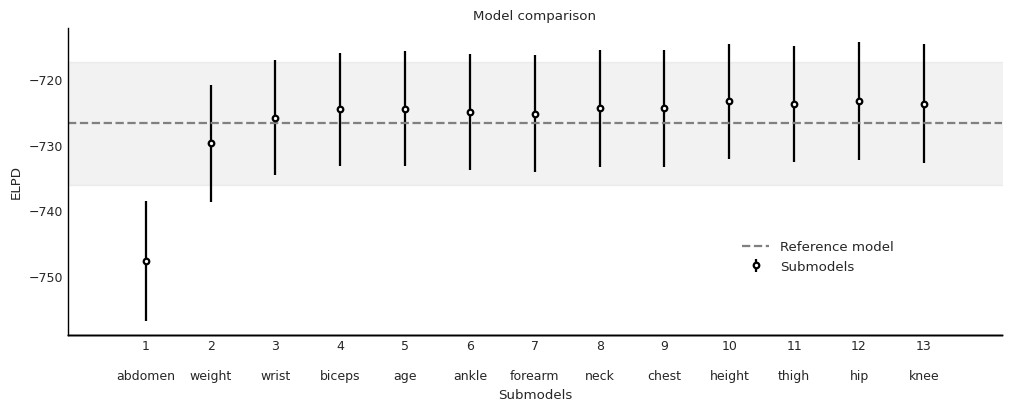

In [5]:
ppi.compare(min_model_size=1);

From this plot we can see that the most relevant variable is `abdomen`, in the sense that if we were forced to pick a single variable, picking `abdomen` would be the one that would make the predictions most similar to the reference model. But the difference of ELPD between the submodel `abdomen` and the reference model is large, so we may want to include more variables. If we include `abdomen`, `weight` and `wrist` we should get a model that is statistically indistinguishable from the reference model (under the ELPD metric). 

The error bars give us an idea of the uncertainty of the ELPD estimate. This is telling us that if we were to repeat the experiment, it will be unlikely not to detect `abdomen` as the most relevant variable, but we should not be surprised, for example, to see some switching between `weight` and `wrist`. And even more for the other variables, for example it makes little sense to argue that `forearm` is more relevant than `hip`.

The `compare` plot provides very useful information, but sometimes we may need a more automated way to select the submodels. This can be done by calling the `select` method. We have two options: `mean` (the default one) and `se`. The first one selects the smallest submodel with an ELPD that is within 4 units of the reference model. The "se" methods selects the smallest submodel with an ELPD that is within one standard error of the reference model. Both criteria behave similarly. Usually, the `mean` criterion results in more stable selection, and selects larger and better-performing submodels {cite}`Mclatchie_2024`.

If we use the `select` method for our example, we see that the selected submodel is the one with `abdomen` and `weight` (plus the intercept).

In [6]:
selected_submodel = ppi.select()
selected_submodel

['Intercept', 'abdomen', 'weight']

As usual statistical methods should help us make decisions, but they should not make decisions for us. When deciding which variables to include in the model we may prefer an order that is slightly different from the one provided by Kulprit, the decision could be based on extra information that is not included in the model. For example, after discussion with domain experts or coworkers, we might determine that weighing patients is too cumbersome and decide to include only `abdomen` and `wrist` measurements.

----

Usually for the purpose of variable selection we do not care about the projections themselves, as they are just an intermediate step to perform variable selection. Nevertheless, it's possible to use and explore the projected posterior. The `plot_densities` function allow us to plot the posterior densities of the submodels (and optionally the reference model too). We can see that the posterior densities of the reference model and the largest submodel (i.e. the reference model projected onto itself) are very similar.

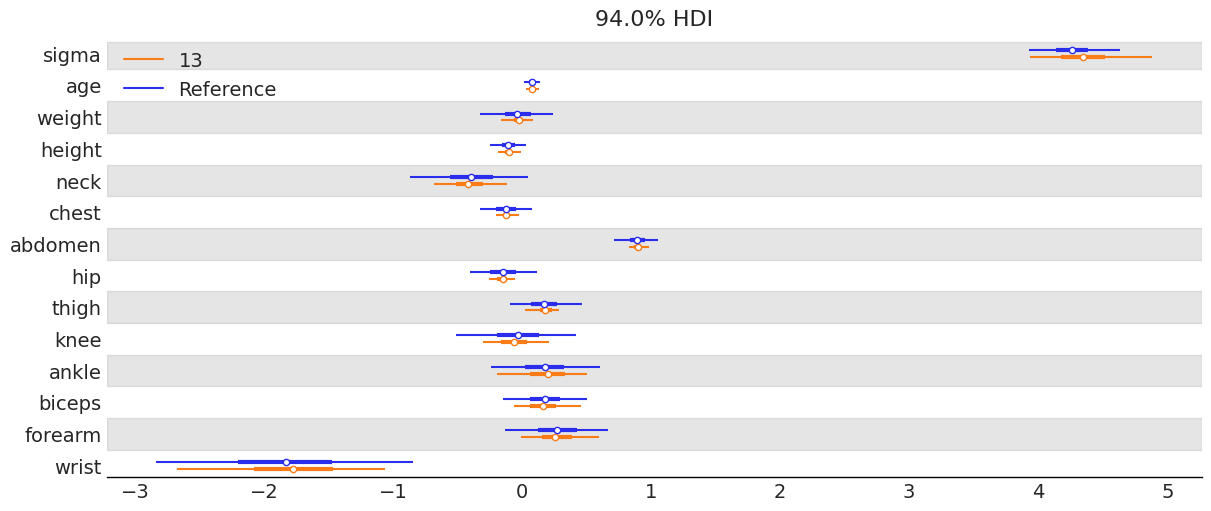

In [7]:
ppi.plot_densities(var_names=["~Intercept", "~mu"],
                   submodels=[13],
                   include_reference=True,
                   kind="forest",
                   plot_kwargs={"figsize": (12, 5)},
                  );

Below we can see the projection for the submodel of size 3, `abdomen + weight + wrist`. By default densities are truncated at 0.94.

/home/osvaldo/anaconda3/envs/kulprit/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['mu'] have not been found and will be ignored
  warnings.warn(


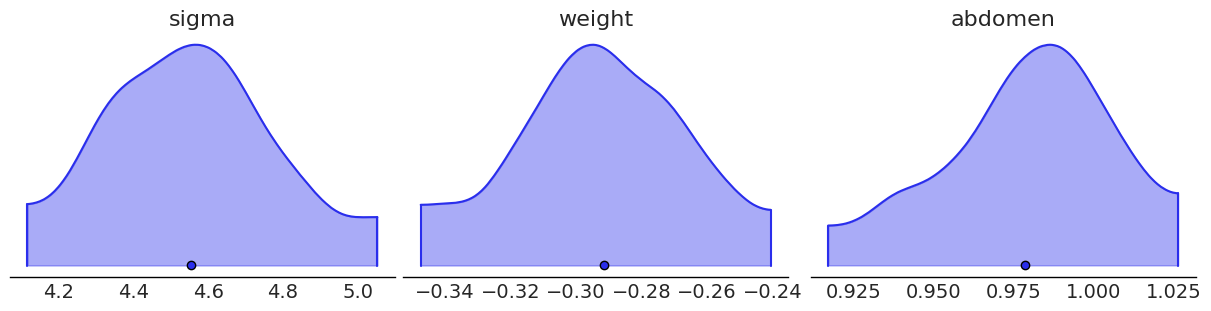

In [8]:
ppi.plot_densities(var_names=["~Intercept", "~mu"],
                   submodels=[selected_submodel.size],
                   figsize=(12, 3),
                   plot_kwargs={"outline": True},
                  );

### Bikes

In [9]:
bikes = pd.read_csv("bikes.csv")

One thing to note is that a linear model may have difficulties to handle the variable `hour` as it will miss the non-linearities in the data. For instance, we expect rentals to go up in the morning and in the evening, and to go down in the middle of the day and at night. To better handle this variable we could transform the variable `hour` into a set of dummy variables like 
 

```python
bikes = pd.read_csv("bikes.csv")
bikes["hour_sin"] = np.sin(bikes.hour * np.pi / 12)
bikes["hour_cos"] = np.cos(bikes.hour * np.pi / 12)
bikes.drop(columns="hour", inplace=True)
``` 

or we could use a more flexible model like splines (that is also a kind of data transformation). Let's try the latter.

In [10]:
knots = range(1, 22, 5)
priors = {
    "alpha": bmb.Prior("Exponential", lam=1)
}

model = bmb.Model("count ~ bs(hour, knots=knots, intercept=True) + " + " + ".join(bikes.columns.drop(["count", "hour"])),
                  bikes,
                  family="negativebinomial",
                  priors=priors)

This time we are going to pass Kulprit the Bambi model without fitting it. Kulprit will take care of fitting the model for us by calling Bambi under the hood.

/home/osvaldo/proyectos/00_BM/bambinos/kulprit/kulprit/projector.py:300: UserWarning: No InferenceData object provided. Building posterior from model.
  warnings.warn("No InferenceData object provided. Building posterior from model.")
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, bs(hour, knots=knots, intercept=True), season, month, holiday, weekday, workingday, weather, temperature, humidity, windspeed]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


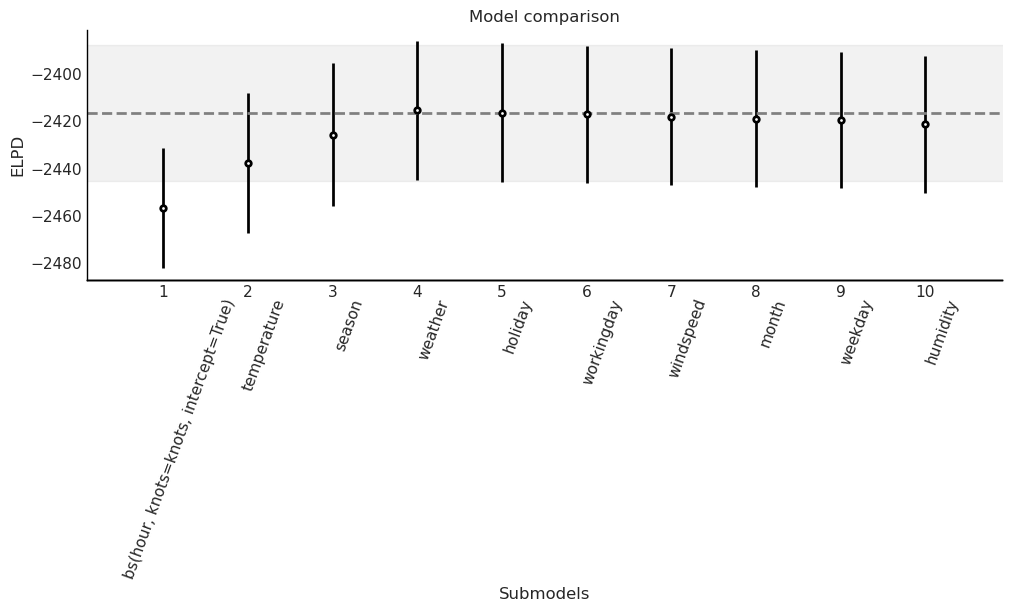

In [11]:
ppi = kpt.ProjectionPredictive(model)
ppi.project()
ppi.compare(
            min_model_size=1,
            plot_kwargs={"xlabel_rotation": 70},
            legend=False,
            figsize=(10, 6),
            );

We can see that `hour` is the more important variable in the model, followed by `temperature` and then the rest of the variables.

## Early stopping

If we have a lot of variables, we may want to stop the projection early. We can do this by setting the `early_stop` argument (defaults to False). We can pass the strings `mean` or `se`, their meaning is the same as in the `select` method. Or we can pass an integer, which will be the number of submodels to project.

/home/osvaldo/proyectos/00_BM/bambinos/kulprit/kulprit/projector.py:300: UserWarning: No InferenceData object provided. Building posterior from model.
  warnings.warn("No InferenceData object provided. Building posterior from model.")
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, bs(hour, knots=knots, intercept=True), season, month, holiday, weekday, workingday, weather, temperature, humidity, windspeed]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


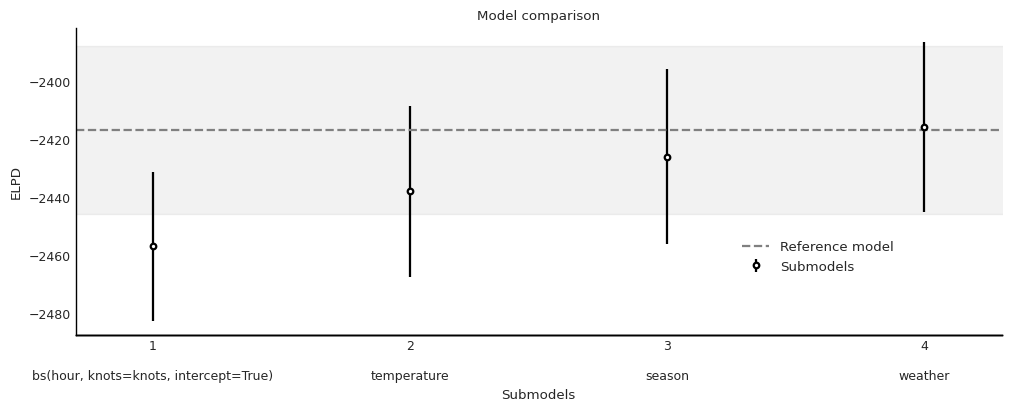

In [12]:
ppi = kpt.ProjectionPredictive(model)
ppi.project(early_stop="mean")
ppi.compare(min_model_size=1);

## Speeding up the projection

There are a few options we can use to speed up the projection. It's important to note that all of them may reduce the accuracy of the results. Still they could be useful if we have numerous variables, and we want to perform a preliminary analysis.

To better understand the options we need to understand how Kulprit works. You can read the [overview](https://kulprit.readthedocs.io/en/latest/examples/overview.html) for details, but in short, Kulprit performs a search over the terms in the model to find the best submodels for each size, and then it evaluates the performance of each selected submodel. The evaluation step is done by projecting each selected submodel and then computing the ELPD (using PSIS-LOO-CV method) {cite:t}`Vehtari_2017, Vehtari_2024`, the result of this evaluation step is what you see when calling `compare` plot. We can affect both how the search and evaluation steps are performed.

One option to speed-up the computation is to set `method="L1"`. This is faster than the default `method="forward"` because no projection is done during the search, instead Kulprit performs a lasso search over the terms. And the projection is done only for the selected submodels. This is useful if we have many variables, and we want to quickly find the best submodels. The downside is that the search step is less accurate as we loose the benefit of the projection during the search.

Another option is to reduce the value of the `num_clusters` argument, which defaults to 20. To speed up the search step Kulprit use a clustering algorithm to group the predictions from the reference model. The clusters are then when performing the projection during the search step. This argument is only used when `method="forward"`.

Another option is to use the `num_samples` argument, which defaults to 400. This is the number of samples used for projection during the evaluation step. A lower value like 100 could still provide reasonable results. 

## References
```{bibliography}
:style: unsrt
```